# Data Pre-Processing
### COVID-19 Daily Infections and Deaths Data
#### Importing dataset

In [67]:
root_path = '/home/amuweee/python_projects/covid_ds/'
import sys
sys.path.append(root_path)

import pandas as pd
import numpy as np
import sqlite3
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from etl.constants import ETLConfigs

# options
%matplotlib inline
pd.options.display.max_rows = 50
pd.options.mode.chained_assignment = None

conn = sqlite3.connect("{}{}.db".format(root_path, ETLConfigs.DB_NAME))
query = "SELECT * FROM {}".format(ETLConfigs.TABLE_NAME)

df = pd.read_sql_query(query, conn)

### Initial view of the dataset
Let's get a quick view of the scope and type of dataset we're dealing with:  
Looking at the top/bottom/random 20 rows, data shape, and datatypes

In [68]:
df.head()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
0,Afghanistan,None,33.0000,65.0000,2020-01-22 00:00:00,0,0,2020-05-30 13:29:08.569254
1,Albania,None,41.1533,20.1683,2020-01-22 00:00:00,0,0,2020-05-30 13:29:08.569254
2,Algeria,None,28.0339,1.6596,2020-01-22 00:00:00,0,0,2020-05-30 13:29:08.569254
3,Andorra,None,42.5063,1.5218,2020-01-22 00:00:00,0,0,2020-05-30 13:29:08.569254
4,Angola,None,-11.2027,17.8739,2020-01-22 00:00:00,0,0,2020-05-30 13:29:08.569254


In [69]:
df.tail()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
454849,US,Utah,39.372319,-111.575868,2020-05-29 00:00:00,4,0,2020-05-30 13:29:08.569254
454850,US,Utah,38.996171,-110.701396,2020-05-29 00:00:00,0,0,2020-05-30 13:29:08.569254
454851,US,Utah,37.854472,-111.441876,2020-05-29 00:00:00,26,0,2020-05-30 13:29:08.569254
454852,US,Utah,40.124915,-109.517442,2020-05-29 00:00:00,-2,0,2020-05-30 13:29:08.569254
454853,US,Utah,41.271160,-111.914512,2020-05-29 00:00:00,12,0,2020-05-30 13:29:08.569254


In [70]:
df.sample(10)

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
207641,US,Illinois,38.413532,-88.057209,2020-03-15 00:00:00,0,0,2020-05-30 13:29:08.569254
366099,US,Texas,30.492738,-96.621585,2020-05-02 00:00:00,1,0,2020-05-30 13:29:08.569254
278110,US,Texas,29.401673,-94.904691,2020-04-05 00:00:00,104,1,2020-05-30 13:29:08.569254
199459,US,Oregon,44.490245,-119.006863,2020-03-12 00:00:00,0,0,2020-05-30 13:29:08.569254
205799,US,North Dakota,48.685657,-99.245643,2020-03-14 00:00:00,0,0,2020-05-30 13:29:08.569254
232258,US,South Dakota,43.580788,-100.756319,2020-03-22 00:00:00,0,0,2020-05-30 13:29:08.569254
198153,US,Kansas,38.914587,-99.317516,2020-03-12 00:00:00,0,0,2020-05-30 13:29:08.569254
310962,US,Virginia,38.836776,-77.275658,2020-04-15 00:00:00,91,1,2020-05-30 13:29:08.569254
189600,US,Oklahoma,36.748172,-102.517388,2020-03-09 00:00:00,0,0,2020-05-30 13:29:08.569254
212058,US,New Jersey,39.475387,-74.658485,2020-03-16 00:00:00,0,0,2020-05-30 13:29:08.569254


In [71]:
df.shape
num_rows = df.shape[0]
num_cols = df.shape[1]

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454854 entries, 0 to 454853
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   country        454854 non-null  object 
 1   state          431118 non-null  object 
 2   latitude       454854 non-null  float64
 3   longitude      454854 non-null  float64
 4   date           454854 non-null  object 
 5   confirmed      454854 non-null  int64  
 6   death          454854 non-null  int64  
 7   etl_load_time  454854 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 27.8+ MB


In [73]:
df.dtypes

country           object
state             object
latitude         float64
longitude        float64
date              object
confirmed          int64
death              int64
etl_load_time     object
dtype: object

### A few observations here:

- We have 350k rows of data and 8 columns
- country, state, longitude, and latitude denoting location in the world (labels)
- state has `None` as null value
- confirmed and death for potential prediction (target)
- date and etl_load_time seems to be stored as `string` rather than `datetime`
- `etl_load_time` seems obsolete for this purpose

Let's drop `etl_load_time` and convert `date` to the proper datatype

In [74]:
df['date'] = df['date'].astype('datetime64', copy=False)
df.drop(columns=['etl_load_time'], inplace=True, errors='ignore')
df.replace({None: np.NaN}, inplace=True)

df.dtypes

country              object
state                object
latitude            float64
longitude           float64
date         datetime64[ns]
confirmed             int64
death                 int64
dtype: object

### Searching and dealing with *null*

Figure out the scope of the nulls  
Visualize missing values with missingno  

In [75]:
print(f"Out of {num_rows} rows")
for i in df:
    missing = df[i].isnull().sum()
    miss_perc = round(missing / num_rows, 3)
    print(f"Row {i} has {missing} nulls, or about {miss_perc}%")

Out of 454854 rows
Row country has 0 nulls, or about 0.0%
Row state has 23736 nulls, or about 0.052%
Row latitude has 0 nulls, or about 0.0%
Row longitude has 0 nulls, or about 0.0%
Row date has 0 nulls, or about 0.0%
Row confirmed has 0 nulls, or about 0.0%
Row death has 0 nulls, or about 0.0%


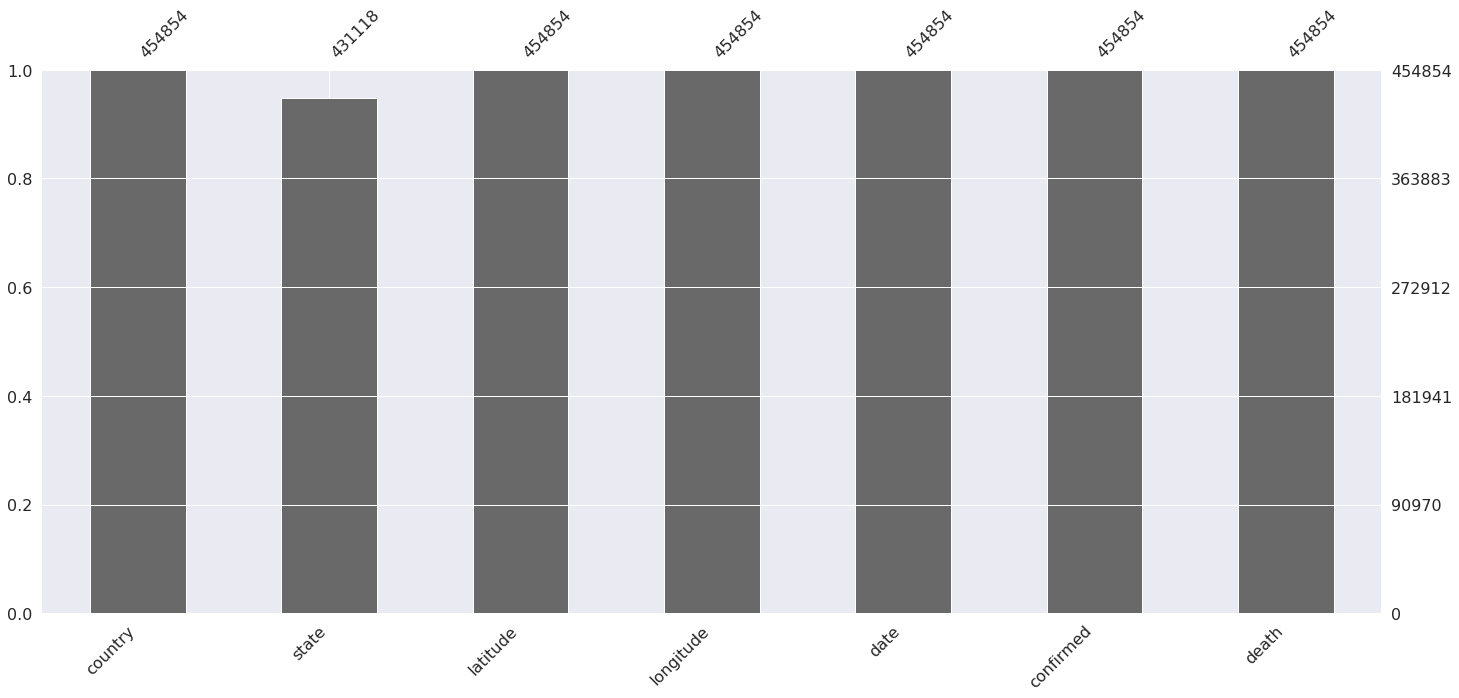

In [76]:
msno.bar(df)

Looks like `longitude` and `latitude` labels both has a small numbers of nulls  
Let's see which index they are are originating form, based on their country and state

In [77]:
log_lat_null_df = df[(
    ((df["longitude"].isnull()) & (df["latitude"].isnull()))
)]
print(log_lat_null_df['country'].unique())
print(log_lat_null_df['state'].unique())

[]
[]


Okay... US and Utah. See if they normally have any values?

In [78]:
log_lat_null_df.groupby(["country"]).sum()

,latitude,longitude,confirmed,death
country,,,,


Nice. No useful values. Let's drop

In [79]:
df_null_step1 = df[(
        ~((df["longitude"].isnull()) & (df["latitude"].isnull()))
    )]
print(f"Previous rows were {num_rows}")
new_num_rows = df_null_step1.shape[0]
print(f"Now there are {new_num_rows}")

Previous rows were 454854
Now there are 454854


Let's repeat for the nulls in state  
Gut feeling is that they are based on countries

In [80]:
country_null_df = df_null_step1[(
    df_null_step1["state"].isnull()
)]

print(country_null_df["country"].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Central African Republic' 'Chad' 'Chile' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lebanon' 'Liberia' 'Liechtenstein' 'Lith

Easiest way to fill these nulls would be to clone the data from countries label for all the countries that we do not have state level data  
For analysis we can later decide whether to group everything at `country` level or treat each `state` as an independent entity

In [81]:
df_null_step1["state"].fillna(df_null_step1["country"], inplace=True)

In [82]:
df_null_step1.info()
df_ready = df_null_step1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454854 entries, 0 to 454853
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   country    454854 non-null  object        
 1   state      454854 non-null  object        
 2   latitude   454854 non-null  float64       
 3   longitude  454854 non-null  float64       
 4   date       454854 non-null  datetime64[ns]
 5   confirmed  454854 non-null  int64         
 6   death      454854 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 27.8+ MB


### Fiding Outliners and deiciding what to do

Taking a look a the daily increments on confirmed and death cases

In [83]:
df_ready["confirmed"].describe()

count    454854.000000
mean         13.024564
std         210.785219
min      -10034.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       26928.000000
Name: confirmed, dtype: float64

In [84]:
df_ready["death"].describe()

count    454854.000000
mean          0.802163
std          17.195107
min       -1918.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1436.000000
Name: death, dtype: float64

Interesting.. some people resurrected from being dead  
See where the outlier or errata of negative increments are happening

In [85]:
df_nkk = df_ready[df_ready["confirmed"]<0]
df_nd = df_ready[df_ready["death"]<0]

print("Countries with negative daily confirmed cases:")
print(df_nkk["country"].unique())
print("Countries with negative daily death cases:")
print(df_nd["country"].unique())

Countries with negative daily confirmed cases:
['Australia' 'France' 'China' 'Guyana' 'Canada' 'United Kingdom' 'Uruguay'
 'Uganda' 'Spain' 'New Zealand' 'Japan' 'Lithuania' 'Mauritius' 'Portugal'
 'Zimbabwe' 'Ecuador' 'San Marino' 'Madagascar' 'Honduras' 'Nepal' 'Benin'
 'US']
Countries with negative daily death cases:
['Iceland' 'Philippines' 'India' 'Kazakhstan' 'Canada' 'Slovakia' 'Serbia'
 'Cyprus' 'Finland' 'Germany' 'Luxembourg' 'Venezuela' 'United Kingdom'
 'Denmark' 'France' 'Czechia' 'Ireland' 'Spain' 'US']


Let's visualize by frequency by countries

In [86]:
# confirmed
df_nkk_sum = df_nkk.groupby(by="country").sum().sort_values(by="confirmed")
df_nkk_cnt = df_nkk.groupby(by="country").count().sort_values(by="confirmed", ascending=False)

# death
df_nd_sum = df_nd.groupby(by="country").sum().sort_values(by="death")
df_nd_cnt = df_nd.groupby(by="country").count().sort_values(by="death", ascending=False)

[Text(0, 0.5, 'count of death')]

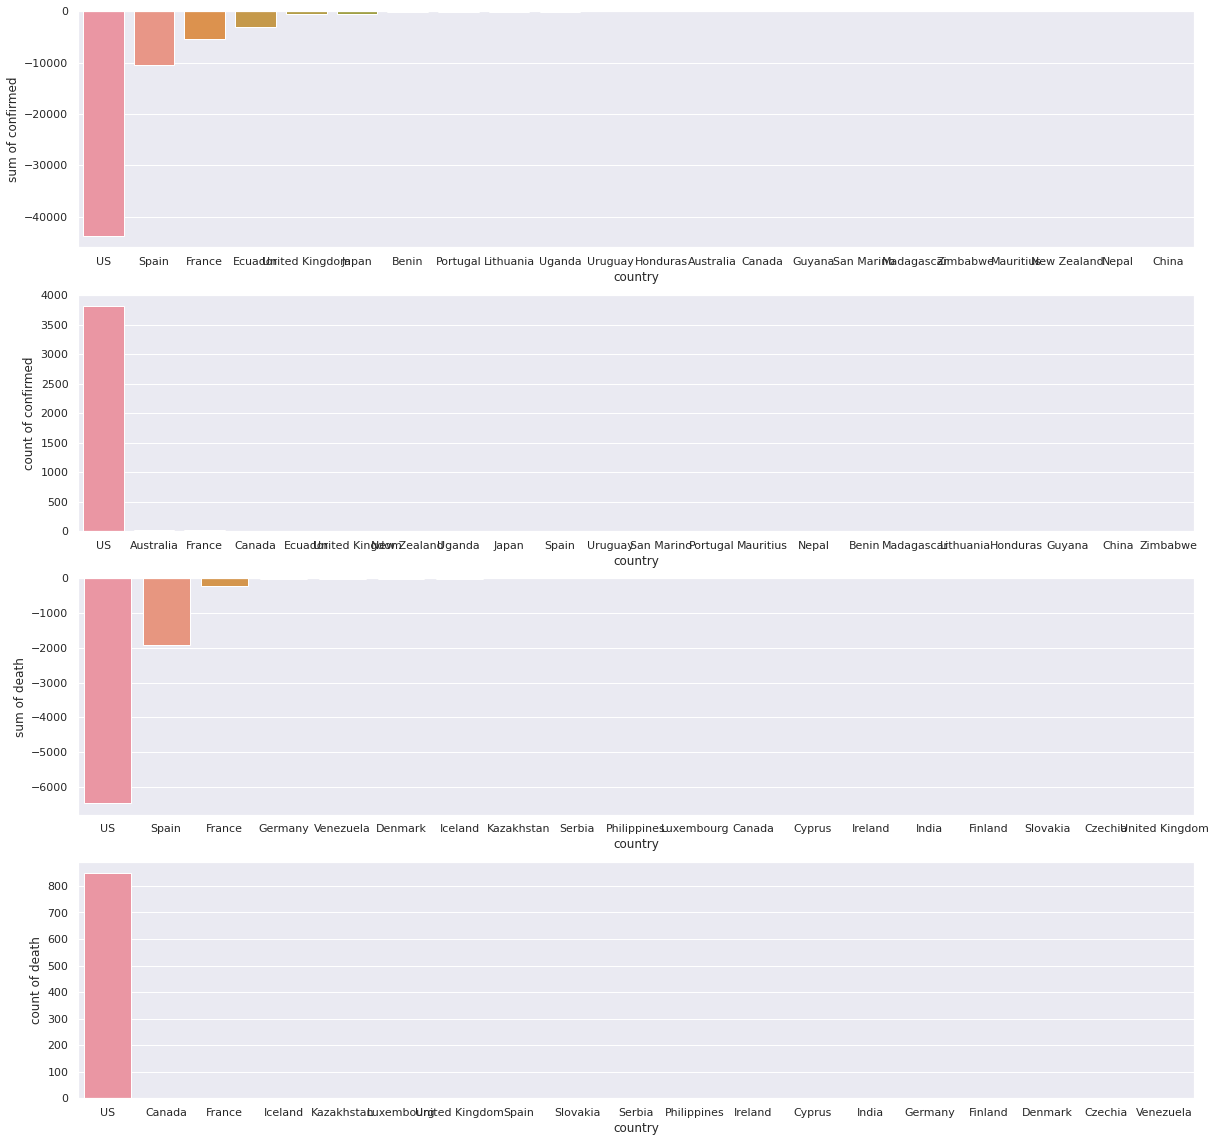

In [87]:
sns.set_style( "darkgrid")
fig, axs = plt.subplots(nrows=4, figsize=(20,20))

sns.barplot(x="country", y="confirmed", data=df_nkk_sum.reset_index(), ax=axs[0]).set(ylabel="sum of confirmed")
sns.barplot(x="country", y="confirmed", data=df_nkk_cnt.reset_index(), ax=axs[1]).set(ylabel="count of confirmed")
sns.barplot(x="country", y="death", data=df_nd_sum.reset_index(), ax=axs[2]).set(ylabel="sum of death")
sns.barplot(x="country", y="death", data=df_nd_cnt.reset_index(), ax=axs[3]).set(ylabel="count of death")

USA looks like the main culprit on negative cases. It is possible that this correction exist to account for errors in the previous days or change in the data collection process that required historical correction.  
In summary:  
- Negative death cases in both volume and count are quite minimal outside of USA
- Negative confirmed cases do have more material effect in volume for Spain and France (maybe Japan as well) outside of USA

Diving into the USA, see if these are coming from specific dates and/or states

In [88]:
df_nkk_usa = df_nkk[df_nkk["country"] == "US"]
df_nkk_usa_date = df_nkk_usa.groupby(by="date").sum().sort_values(by="date")
df_nkk_usa_date.head(20)

,latitude,longitude,confirmed,death
date,,,,
2020-03-11,19.601212,-155.521017,-6,0
2020-03-12,301.730465,-708.112571,-12,0
2020-03-13,318.358489,-833.328075,-12,0
2020-03-14,221.834003,-630.460144,-58,0
2020-03-15,298.501908,-827.023895,-120,1
2020-03-16,184.558526,-451.677936,-5,0
2020-03-17,205.884998,-499.415861,-6,0
2020-03-18,390.478751,-925.446428,-20,10
2020-03-19,210.604856,-579.873451,-8,1


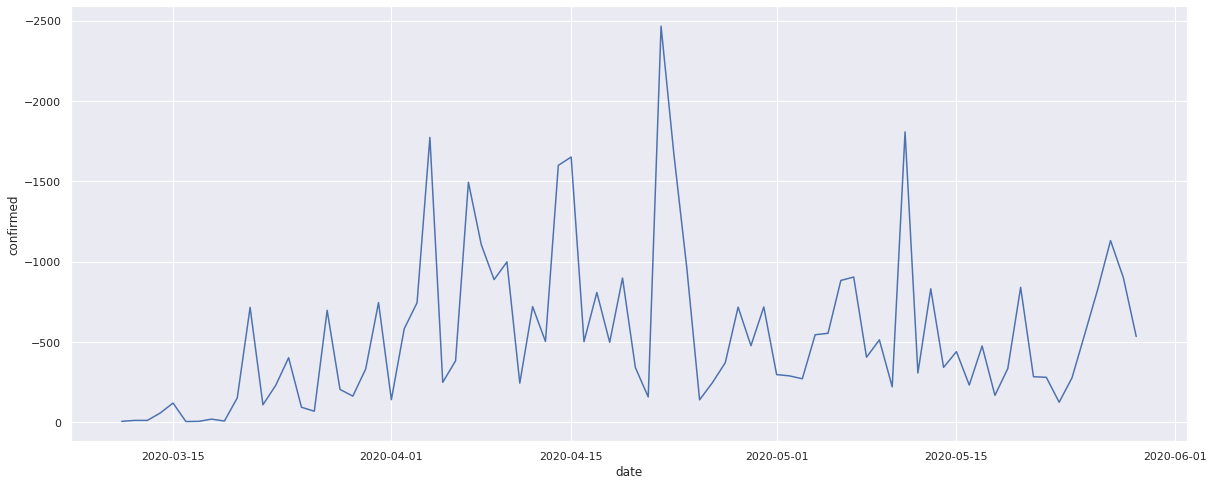

In [89]:
# Visualize as timeseries 
sns.set_style( "darkgrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(x="date", y="confirmed", data=df_nkk_usa_date.reset_index().sort_values(by="date")).invert_yaxis()

Hmm.. doesn't quite tell us much, other than that data is more erratic starting March 11th  
See whether viewing this by the sate would give us better understanding

In [90]:
df_nkk_usa_state = df_nkk_usa.groupby(by="state").sum().sort_values(by="confirmed")
df_nkk_usa_state.head(20)

,latitude,longitude,confirmed,death
state,,,,
New Jersey,487.744233,-892.062252,-11212,65
Georgia,12403.488245,-31745.715909,-5557,30
Rhode Island,416.631930,-714.720638,-4717,0
Illinois,5749.138686,-12848.460562,-2105,7
Tennessee,5277.290873,-12644.256212,-2031,6
Massachusetts,166.801439,-284.648930,-1999,3
Washington,2223.115531,-5688.534579,-1825,8
New York,896.457242,-1588.152233,-1475,53
Michigan,6310.665770,-12213.088487,-1234,110


New Jeysey seems the biggest culprit. Let's dive down on that state and see whether we can figure out what's causing the negative

In [91]:
df_new_jersey = df[(df["state"] == "New Jersey") & (df["confirmed"] < 0)]
df_new_jersey

,country,state,latitude,longitude,date,confirmed,death
225105,US,New Jersey,39.803438,-74.963888,2020-03-20,-2,0
226552,US,New Jersey,0.000000,0.000000,2020-03-20,-16,0
244668,US,New Jersey,39.475387,-74.658485,2020-03-26,-2,0
262423,US,New Jersey,0.000000,0.000000,2020-03-31,-161,0
272206,US,New Jersey,0.000000,0.000000,2020-04-03,-58,0
275467,US,New Jersey,0.000000,0.000000,2020-04-04,-873,0
278728,US,New Jersey,0.000000,0.000000,2020-04-05,-114,0
281989,US,New Jersey,0.000000,0.000000,2020-04-06,-300,0
285250,US,New Jersey,0.000000,0.000000,2020-04-07,-1314,12
288511,US,New Jersey,0.000000,0.000000,2020-04-08,-816,-12


Interestingly the ones with extreme values do not have any latitude or longitude data.  
Let's put it into a timeseries graph to see if they the extremes have significant impact on the daily set

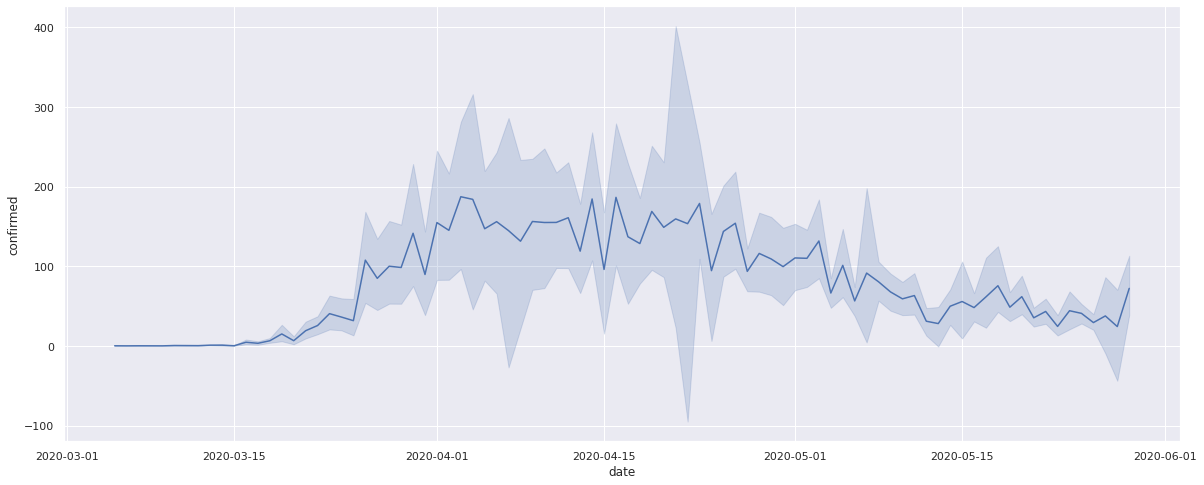

In [92]:
data_nj = df[df["state"] == "New Jersey"]
data_nj["confirmed_cumsum"] = data_nj["confirmed"].cumsum()
data_nj_plot = data_nj[data_nj["confirmed_cumsum"] > 0]

sns.lineplot(x="date", y="confirmed", data=data_nj_plot)

Looking at the confidence interval, the area there there is a big dip towards (or below) the 0 on y-axis, there is also a proportionally large outlier on the maximum side in that day.  
This actually gives a good confident that as long as the `confirmed` measure is aggreagated at `state` and `date` level, the anomaly should cancel each other out and give us a normalized daily cases. It is looking quite likely that these daily negatives are some sort of adjustment or error correction at the state level  
Let's test on Georgia, the second highest state with anomalies

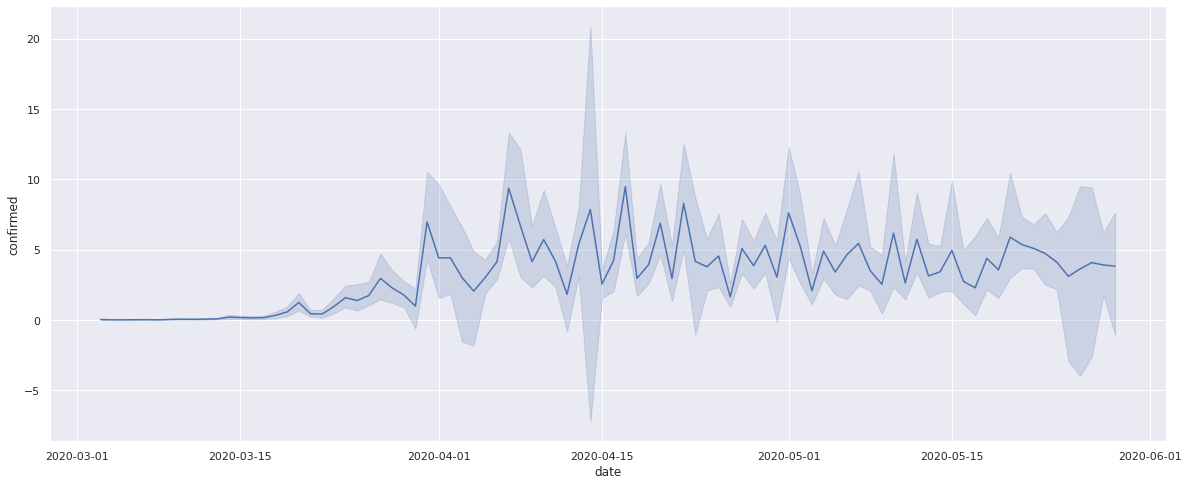

In [93]:
data_geo = df[df["state"] == "Georgia"]
data_geo["confirmed_cumsum"] = data_geo["confirmed"].cumsum()
data_geo_plot = data_geo[data_geo["confirmed_cumsum"] > 0]

sns.lineplot(x="date", y="confirmed", data=data_geo_plot)

The same trend is observed. This is good, we can we more confident that aggregated data should be representative of the daily cases at state level  
Let's look quickly look at Spain and France to see whether the same is happening

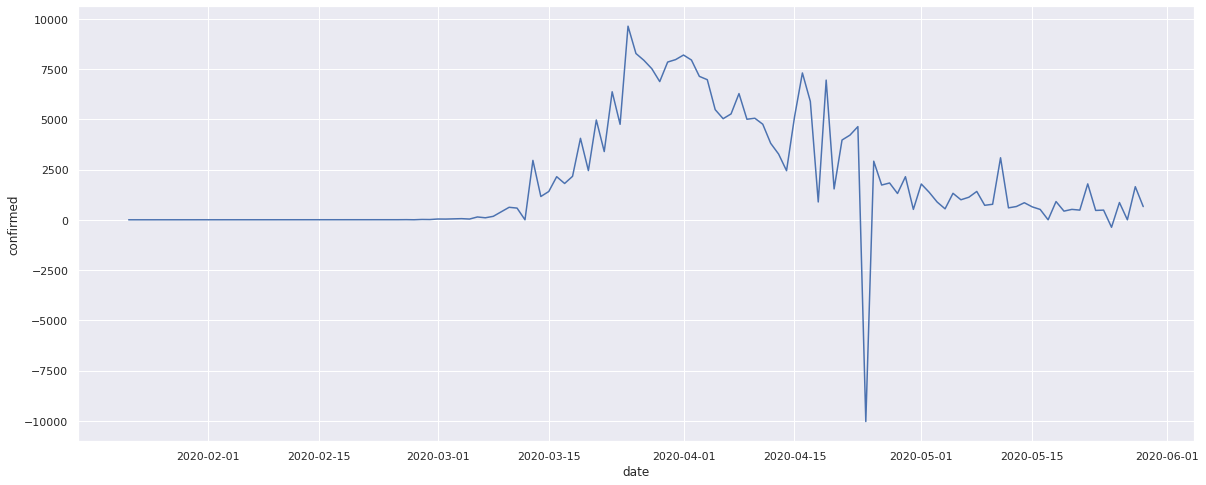

In [94]:
df_spain = df_ready[df_ready["country"] == "Spain"]
df_spain["confirmed_cumsum"] = df_spain["confirmed"].cumsum()
df_spain_plot = df_spain[df_spain["confirmed_cumsum"] > 0]

sns.lineplot(x="date", y="confirmed", data=df_spain)

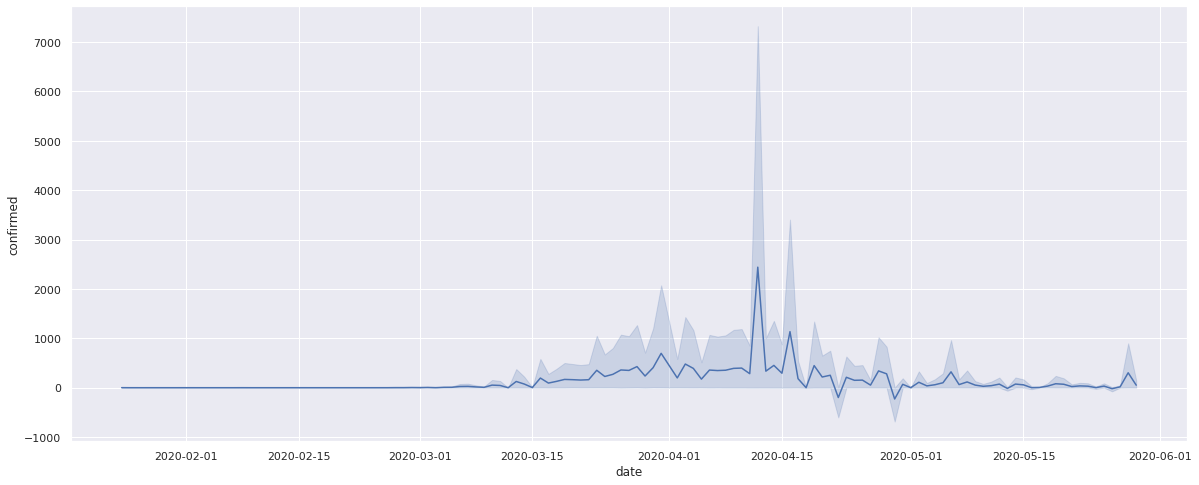

In [95]:
df_france = df_ready[df_ready["country"] == "France"]
df_france["confirmed_cumsum"] = df_france["confirmed"].cumsum()
df_france_plot = df_france[df_france["confirmed_cumsum"] > 0]

sns.lineplot(x="date", y="confirmed", data=df_france_plot)

That's problematic. Spain has one adjustment day of -1k cases on April 24th, France has both negative days and a spike in increase around April 12th.  
Though there seems to be some explanation from the maintainer of the source data:

- [Frech Data](https://github.com/CSSEGISandData/COVID-19/issues/2459): Inclusion of probable data since April 14
- [Spanish Data](https://github.com/CSSEGISandData/COVID-19/issues/2448): There was a sync to the official Spanish numbers and recorded the negative 10k as and adjustment as made to the timeseries data for correction

Although these data are not necessarily wrong, it could introduce unwanted bias when using it. Before we move on though, let's take a look at a few more top infected countries and their outliers

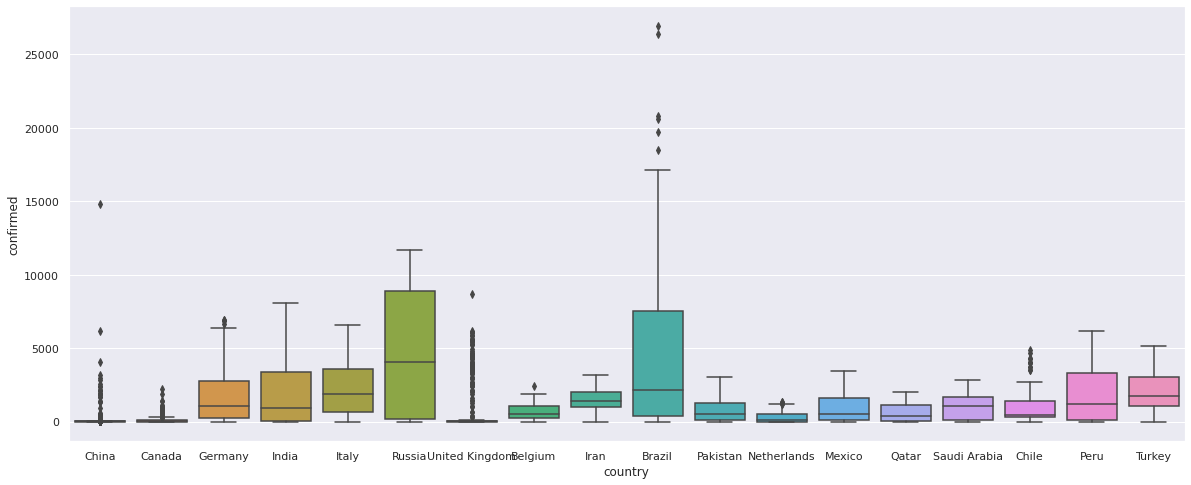

In [96]:
df_country = df_ready.groupby(by=["country"]).sum().sort_values(by="confirmed", ascending=False).reset_index()
list_top = df_country.loc[:20, "country"].to_list()
excl = ["US", "France", "Spain"]
list_top = [i for i in list_top if i not in excl]
df_box_plot = df_ready[
    ((df_ready["country"].isin(list_top)) & (df_ready["confirmed"] > 0))
]
sns.boxplot(x="country", y="confirmed", data=df_box_plot)

Looking at the top countries by confirmed cases, the box plot it does seem like outliers are quite abundant in majority of cases. Especially in China, Canada, and United Kingdom. We still want to normalize these data however so that we can infer statistical significance using all the datapoints. 

In [97]:
z_score = np.abs(stats.zscore(df_ready["confirmed"]))
outlier_index = np.where(z_score > 3)

len(outlier_index[0])

1597